<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/ModelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from keras_preprocessing import text,sequence
from tensorflow import keras
import pickle
import numpy as np
import pandas as pd
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mount le drive pour accéder aux modèles enregistrés (Créer un raccourci du drive partagé dans votre propre drive google)

https://drive.google.com/drive/folders/1aIAK0Qi-pofkSLi3xijkAex-JrSW_tn8?usp=sharing

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mettre le lien du modèle et du tokenizer ici (Pour avoir plus simple, vous pouvez créer un racourci du drive partagé dans votre propre drive, vous n'aurez pas besoin de changer quoiqu'il soit dans le code alors; Pour cela, il suffit de faire clique droit sur le folder "Challenge2" et appuyer sur "Ajouter un raccourci dans Drive")

In [15]:
path_to_load = '/content/drive/MyDrive/Challenge2/modelF.h5'
tokenizer_path = '/content/drive/MyDrive/Challenge2/tokenizer.pickle'

In [16]:
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [17]:
model = keras.models.load_model(path_to_load)

Lire les données à tester et retirer les colonnes inutiles
Renommer les colonnes avec le text en "data" et les colonnes avec les label en "label"

In [18]:
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

Nettoyage des données

In [19]:
STOPWORDS = set(stopwords.words('french'))
moreStopwords = ['plus', 'comme', 'a', 'il', 'alors','au',
'aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci',
'comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','début',
'elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il',
'ils','je',	'juste','la','le','les','leur','là','ma','maintenant','mais','mes','mien','moins','mon',
'mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour',
'pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si',
'sien','son','sont','sous','soyez',	'sujet','sur','ta','tandis','tellement','tels','tes','ton','tous',
'tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être']

STOPWORDS.update(moreStopwords)
def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

df_test['data'] = df_test['data'].apply(cleaner)

In [20]:
x_test = df_test["data"]
y_test = df_test["label"]

Vectorisation + padding

In [21]:
max_features = 10000
maxlen = 512
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

Evaluation

In [22]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

16/16 [==============================] - 4s 198ms/step - loss: 0.0583 - accuracy: 0.9856
Accuracy of the model on Testing Data is -  98.55967164039612 %


In [23]:
pred = model.predict(X_test)

16/16 [==============================] - 4s 194ms/step


In [24]:
pred = np.round(pred)

Toutes les lignes mal prédites

In [25]:
wrong = []
for i in range(len(pred)):
  if pred[i]!=y_test[i]:
    wrong.append(i)
wrong

[12, 22, 31, 127, 128, 156, 220]

Création de la matrice de confusion

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(classification_report(list(y_test), np.round(pred).astype(int), target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       1.00      0.97      0.99       272
        Fake       0.97      1.00      0.98       214

    accuracy                           0.99       486
   macro avg       0.98      0.99      0.99       486
weighted avg       0.99      0.99      0.99       486



In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,np.round(pred).astype(int))
cm
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

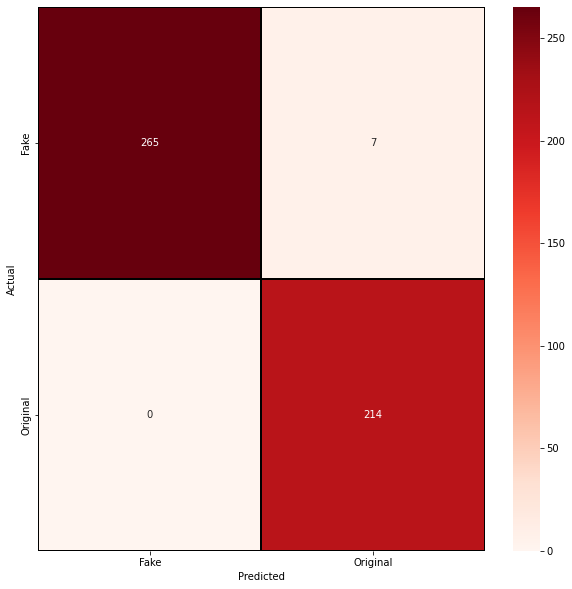

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")